In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings

warnings.filterwarnings("ignore")

# Training a Model to predict lowest price bidded.

**Problem:** The shipper wants to know if the current price is the lowest bidded
one or not.

- If not, he might want to wait for a better price.
- If yes, he might want to accept the current price.

**Solution:** We will train a model to predict the lowest price bidded, given
the information we have at the time of the bid.

**Opportunity:** The shipper can use this model to decide if he wants to accept
the current price or wait for a better one, this can influence his user experience
if he wants to rate shop. We can also use this model to show the shipper levels
of confidence that the current price is the lowest.

**Data:** We will use the same data as in the previous notebook.

**Methodoly:** We will train a series of very simple models and use a time-series
cross-validation to respect the time component of the data.


## Preparing the data


In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [4]:
feature_columns = [
    "sqr_quote_created",
    "quote_type",
    "equipment_type",
    "origin_zip3",
    "origin_kma",
    "origin_state",
    "origin_country",
    "dest_zip3",
    "dest_kma",
    "dest_state",
    "dest_country",
    "shipper_plan",
    "shipper_origin",
    "quoting_channel",
    "flat_rate",
    "mileage",
    "lane_type",
    "award_type",
    "service_level",
    "origin_type",
    "load_channel",
    "rpm",
    "days_en_route",
    "del_b4_pu",
    "is_weekend_pickup",
    "delivery_date_epoch",
    "pickup_date_epoch",
    "is_weekend_delivery",
    "is_next_day_trip",
    "is_next_week_trip",
    "is_weekend_trip",
    "lead_time_quote",
    "lead_time_rate",
    "quote_age",
    "pickup_date_year",
    "pickup_date_month",
    "pickup_date_quarter",
    "pickup_date_week",
    "pickup_date_day",
    "pickup_date_hour",
    "pickup_date_dow",
    "pickup_date_doy",
    "pickup_date_is_holiday",
    "pickup_date_month_start",
    "pickup_date_month_end",
    "pickup_date_weekend",
    "delivery_date_year",
    "delivery_date_month",
    "delivery_date_quarter",
    "delivery_date_week",
    "delivery_date_day",
    "delivery_date_hour",
    "delivery_date_dow",
    "delivery_date_doy",
    "delivery_date_is_holiday",
    "delivery_date_month_start",
    "delivery_date_month_end",
    "delivery_date_weekend",
    "sqr_quote_created_year",
    "sqr_quote_created_month",
    "sqr_quote_created_quarter",
    "sqr_quote_created_week",
    "sqr_quote_created_day",
    "sqr_quote_created_hour",
    "sqr_quote_created_dow",
    "sqr_quote_created_doy",
    "sqr_quote_created_is_holiday",
    "sqr_quote_created_month_start",
    "sqr_quote_created_month_end",
    "sqr_quote_created_weekend",
    "sqr_quote_created_epoch",
    "rate_date_year",
    "rate_date_month",
    "rate_date_quarter",
    "rate_date_week",
    "rate_date_day",
    "rate_date_hour",
    "rate_date_dow",
    "rate_date_doy",
    "rate_date_is_holiday",
    "rate_date_month_start",
    "rate_date_month_end",
    "rate_date_weekend",
    "rate_date_epoch",
    "flat_rate_mean",
    "flat_rate_std",
    "flat_rate_median",
    "flat_rate_min",
    "flat_rate_max",
    "flat_rate_count",
    "rate_above_mean",
    "rate_above_median",
    "rate_is_currently_lowest",
    "rate_is_currently_high",
    "is_lowest_rate",
]

In [5]:
features = pd.read_parquet("data/features.parquet")

In [6]:
features = features[feature_columns]

In [7]:
features

,sqr_quote_created,quote_type,equipment_type,origin_zip3,origin_kma,origin_state,origin_country,dest_zip3,dest_kma,dest_state,...,flat_rate_std,flat_rate_median,flat_rate_min,flat_rate_max,flat_rate_count,rate_above_mean,rate_above_median,rate_is_currently_lowest,rate_is_currently_high,is_lowest_rate
0,2023-02-01 06:54:42,is_agnostic,FBE,481,MI_DET,MI,USA,230,VA_RCH,VA,...,NaN,2339.100,2339.1,2339.10,1.0,False,False,True,True,False
1,2023-02-01 06:54:42,is_agnostic,FBE,481,MI_DET,MI,USA,230,VA_RCH,VA,...,7.707464,2344.550,2339.1,2350.00,2.0,True,True,False,True,False
2,2023-02-01 06:54:42,is_agnostic,FBE,481,MI_DET,MI,USA,230,VA_RCH,VA,...,31.962530,2339.100,2290.0,2350.00,3.0,False,False,True,False,False
3,2023-02-01 06:54:42,is_agnostic,FBE,481,MI_DET,MI,USA,230,VA_RCH,VA,...,91.963956,2314.550,2150.0,2350.00,4.0,False,False,True,False,False
4,2023-02-01 06:54:42,is_agnostic,FBE,481,MI_DET,MI,USA,230,VA_RCH,VA,...,103.477350,2339.100,2150.0,2430.00,5.0,True,True,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50143,2023-08-09 12:10:57,is_agnostic,DRV,774,TX_HOU,TX,USA,330,FL_MIA,FL,...,249.205643,2871.215,2695.0,3047.43,2.0,False,False,True,False,True
50144,2023-08-09 12:10:57,is_agnostic,DRV,774,TX_HOU,TX,USA,330,FL_MIA,FL,...,235.734847,2695.000,2600.0,3047.43,3.0,False,False,True,False,True
50145,2023-08-09 12:10:57,is_agnostic,DRV,774,TX_HOU,TX,USA,330,FL_MIA,FL,...,193.286535,2755.580,2600.0,3047.43,4.0,True,True,False,False,False
50146,2023-08-09 12:10:57,is_agnostic,DRV,774,TX_HOU,TX,USA,330,FL_MIA,FL,...,187.651268,2695.000,2600.0,3047.43,5.0,False,False,True,False,True


In [8]:
# finding features with no variation in the data
constant_col = []
for col in features.columns:
    if features[col].nunique() == 1:
        constant_col.append(col)

In [9]:
constant_col

['service_level',
 'del_b4_pu',
 'pickup_date_year',
 'pickup_date_hour',
 'delivery_date_year',
 'delivery_date_hour',
 'sqr_quote_created_year',
 'rate_date_year']

In [10]:
features = features.drop(constant_col, axis=1)

In [11]:
# find all non numeric columns and set them as category
numerical_features = []
categorical_features = []
for col in features.columns:
    if features[col].dtype in ["object", "str", "string"]:
        features[col] = features[col].astype("category")
        categorical_features.append(col)
    elif features[col].dtype in ["bool", "boolean", bool]:
        features[col] = features[col].astype(int)
        numerical_features.append(col)
    else:
        numerical_features.append(col)
numerical_features.remove("sqr_quote_created")
numerical_features.remove("is_lowest_rate")

## Quick analysis


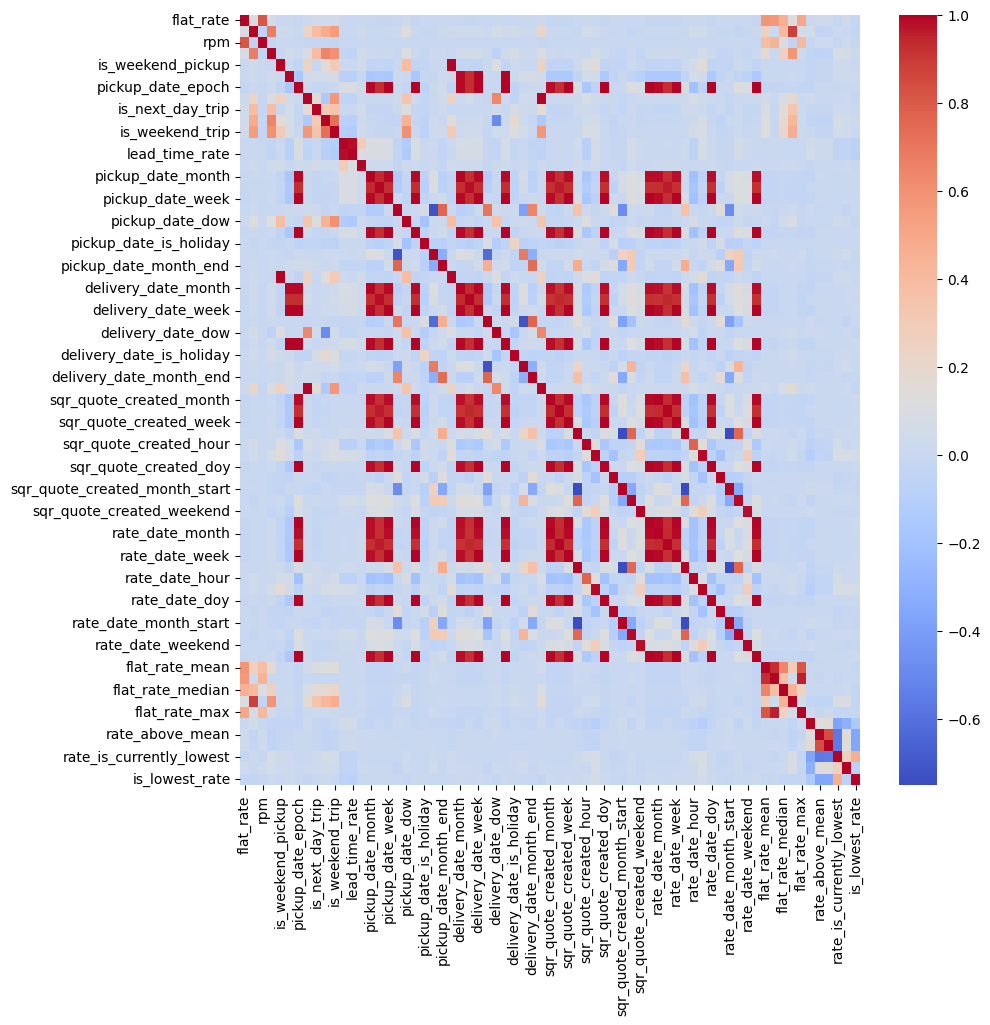

In [12]:
import seaborn as sns


def plot_correlation(data):
    fig, ax = plt.subplots(figsize=(10, 10))
    sns.heatmap(data.corr(), annot=False, ax=ax, cmap="coolwarm")
    plt.show()


plot_correlation(features)

The last line/column is the target variable.

As we can see, the target variable is correlated to some of the other rate features.


In [13]:
y = features["is_lowest_rate"].copy(deep=True)
y

0        0
1        0
2        0
3        0
4        0
        ..
50143    1
50144    1
50145    0
50146    1
50147    0
Name: is_lowest_rate, Length: 50148, dtype: int64

In [35]:
y.value_counts()

0    39994
1    10154
Name: is_lowest_rate, dtype: int64

In [36]:
y.value_counts() / y.shape[0]

0    0.797519
1    0.202481
Name: is_lowest_rate, dtype: float64

As we can see, the problem is unbalanced, with the ration being close to 80/20.


In [14]:
X = features.drop(["is_lowest_rate", "sqr_quote_created"], axis=1)

In [15]:
# replace infinity for NaN in the dataframe X
import numpy as np

X = X.replace([np.inf, -np.inf], np.nan)

In [16]:
categorical_features

['quote_type',
 'equipment_type',
 'origin_zip3',
 'origin_kma',
 'origin_state',
 'origin_country',
 'dest_zip3',
 'dest_kma',
 'dest_state',
 'dest_country',
 'shipper_plan',
 'shipper_origin',
 'quoting_channel',
 'lane_type',
 'award_type',
 'origin_type',
 'load_channel']

## Building the transdformer pipeline

Below we use Sklearn's transformer pipeline to:

- Impute missing values depending on the feature type
- Scale the features using a StandardScaler, which is a requirement to use Logistic Regression.
- Treat categorical features as dummy variables using One Hot Encoding


In [17]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from utils import ConstantImputer
from sklearn.compose import make_column_transformer

SimpleImputer.get_feature_names_out = lambda self, names=None: self.feature_names_in_

numerical_transformer = make_pipeline(
    SimpleImputer(strategy="median"), StandardScaler()
)
categorical_transformer = make_pipeline(
    ConstantImputer(), OneHotEncoder(handle_unknown="ignore")
)
transformer = make_column_transformer(
    (numerical_transformer, numerical_features),
    (categorical_transformer, categorical_features),
)

In [18]:
results = []

## Using a Dummy Classifier

This classifier will just predict randomly based on the distribution of the y.

This will be a horrible model, but can be used as a baseline.

This highlights why you **must** use many metrics besides accuracy when evaluating
classification, as each one has their trade-offs.


In [19]:
y.value_counts()

0    39994
1    10154
Name: is_lowest_rate, dtype: int64

In [20]:
from utils import time_series_validation


regressor = DummyClassifier(strategy="stratified", random_state=42)
pipe = make_pipeline(transformer, regressor)
result = time_series_validation(X, y, base_data=features, model=pipe)

Executing fold 0
Executing fold 1
Executing fold 2
Executing fold 3
Executing fold 4
Executing fold 5
Executing fold 6
Executing fold 7
Executing fold 8
Executing fold 9


In [21]:
result

,fold,n_train,n_test,f1_train,recall_train,precision_train,roc_auc_train,accuracy_train,f1_validation,recall_validation,precision_validation,roc_auc_validation,accuracy_validation,true_postive_validation,false_postive_validation,true_negative_validation,false_negative_validation
0,0,30708,1750,0.185893,0.185467,0.186320,0.496338,0.687671,0.200290,0.200000,0.200581,0.502135,0.685143,0.039429,0.157143,0.645714,0.157714
1,1,32458,2072,0.186259,0.186110,0.186408,0.496218,0.686918,0.193548,0.183258,0.205063,0.495310,0.674228,0.039093,0.151544,0.635135,0.174228
2,2,34530,1912,0.187992,0.187416,0.188571,0.496794,0.686273,0.165375,0.160804,0.170213,0.477364,0.662134,0.033473,0.163180,0.628661,0.174686
3,3,36442,1840,0.189224,0.188743,0.189707,0.497022,0.685363,0.205584,0.191489,0.221918,0.495533,0.659783,0.044022,0.154348,0.615761,0.185870
4,4,38282,1615,0.190635,0.189963,0.191313,0.496964,0.683480,0.188060,0.181556,0.195046,0.488254,0.663158,0.039009,0.160991,0.624149,0.175851
5,5,39897,1714,0.191254,0.190609,0.191904,0.496859,0.682457,0.188425,0.177215,0.201149,0.483225,0.648191,0.040840,0.162194,0.607351,0.189615
6,6,41611,1977,0.192088,0.191786,0.192392,0.496289,0.679988,0.215205,0.200000,0.232911,0.500132,0.660597,0.046535,0.153263,0.614062,0.186141
7,7,43588,2042,0.193296,0.192908,0.193686,0.496121,0.678099,0.198265,0.201511,0.195122,0.500452,0.683154,0.039177,0.161606,0.643976,0.155240
8,8,45630,2354,0.192963,0.192624,0.193303,0.496036,0.678282,0.211577,0.201521,0.222689,0.499557,0.664401,0.045030,0.157179,0.619371,0.178420
9,9,47984,2164,0.194377,0.194044,0.194711,0.496180,0.676955,0.212500,0.197292,0.230248,0.495124,0.650647,0.047135,0.157579,0.603512,0.191774


In [22]:
results_dummy = (
    result.describe()
    .loc[["mean", "std", "50%"], :]
    .T.iloc[1:, :]
    .reset_index()
    .rename(columns={"index": "metric"})
)

In [23]:
results_dummy["model"] = "Dummy"
results.append(results_dummy)

results_dummy

,metric,mean,std,50%,model
0,n_train,39113.000000,5694.129101,39089.500000,Dummy
1,n_test,1944.000000,224.646389,1944.500000,Dummy
2,f1_train,0.190398,0.002964,0.190945,Dummy
3,recall_train,0.189967,0.002966,0.190286,Dummy
4,precision_train,0.190831,0.002971,0.191608,Dummy
5,roc_auc_train,0.496482,0.000382,0.496313,Dummy
6,accuracy_train,0.682549,0.003998,0.682969,Dummy
7,f1_validation,0.197883,0.015011,0.199278,Dummy
8,recall_validation,0.189465,0.013542,0.194391,Dummy
9,precision_validation,0.207494,0.019421,0.203106,Dummy


## Using Logistic Regression

We will use the logistic regression with all features, even the uncorrelated ones.

This will give better results from compared to the previous model, with not signs of overfitting.

But because we have too many unrelated variables, the model will use L2 regularization to reduce the weights of the unrelated variables.


In [24]:
regressor = LogisticRegression(penalty="l2", n_jobs=-1, random_state=42, max_iter=1000)
pipe = make_pipeline(transformer, regressor)
result = time_series_validation(X, y, base_data=features, model=pipe)

Executing fold 0


Executing fold 1
Executing fold 2
Executing fold 3
Executing fold 4
Executing fold 5
Executing fold 6
Executing fold 7
Executing fold 8
Executing fold 9


In [25]:
results_logit = (
    result.describe()
    .loc[["mean", "std", "50%"], :]
    .T.iloc[1:, :]
    .reset_index()
    .rename(columns={"index": "metric"})
)
results_logit["model"] = "Logistic Regression (Logit)"
results.append(results_logit)
results_logit

,metric,mean,std,50%,model
0,n_train,39113.000000,5694.129101,39089.500000,Logistic Regression (Logit)
1,n_test,1944.000000,224.646389,1944.500000,Logistic Regression (Logit)
2,f1_train,0.704459,0.004538,0.705163,Logistic Regression (Logit)
3,recall_train,0.649506,0.006917,0.650005,Logistic Regression (Logit)
4,precision_train,0.769602,0.001487,0.769575,Logistic Regression (Logit)
5,roc_auc_train,0.925724,0.001216,0.925653,Logistic Regression (Logit)
6,accuracy_train,0.892901,0.002830,0.892956,Logistic Regression (Logit)
7,f1_validation,0.611215,0.056661,0.614388,Logistic Regression (Logit)
8,recall_validation,0.554789,0.093877,0.566160,Logistic Regression (Logit)
9,precision_validation,0.696334,0.069944,0.696967,Logistic Regression (Logit)


### Top 10 features


In [26]:
fitted_pipe = pipe.fit(X, y)
pd.DataFrame(
    [
        fitted_pipe[:-1].get_feature_names_out().T,
        fitted_pipe[-1].coef_.T,
        np.abs(fitted_pipe[-1].coef_.T),
    ],
    index=["features", "coefficients", "abs_coeff"],
).T.sort_values("abs_coeff", ascending=False)[["features", "coefficients"]].head(10)

,features,coefficients
0,pipeline-1__flat_rate,[-23.703595031630595]
1293,pipeline-2__quoting_channel_alice,[-3.135533327332468]
108,pipeline-2__origin_zip3_142,[2.64828608128094]
2,pipeline-1__rpm,[-2.4491239063702004]
278,pipeline-2__origin_zip3_608,[2.439939889083477]
715,pipeline-2__dest_zip3_293,[2.221755027911934]
760,pipeline-2__dest_zip3_356,[2.2202718934966486]
1295,pipeline-2__quoting_channel_rfp-backend,[2.191221496059581]
471,pipeline-2__origin_kma_NY_BUF,[2.112084541752171]
319,pipeline-2__origin_zip3_761,[-2.047821508526618]


## Removing weak features using ANOVA

I'll just keep 10 features with the best F-value from the ANOVA, this will remove the features with weak effects on the target variable.


In [27]:
from sklearn.feature_selection import SelectKBest, f_classif

selector = SelectKBest(f_classif, k=10)

pipe = make_pipeline(transformer, selector, regressor)

In [28]:
result = time_series_validation(X, y, base_data=features, model=pipe)
results_logit_sel = (
    result.describe()
    .loc[["mean", "std", "50%"], :]
    .T.iloc[1:, :]
    .reset_index()
    .rename(columns={"index": "metric"})
)
results_logit_sel["model"] = "Logit + Selection"
results.append(results_logit_sel)
results_logit_sel

Executing fold 0
Executing fold 1
Executing fold 2
Executing fold 3
Executing fold 4
Executing fold 5
Executing fold 6
Executing fold 7
Executing fold 8
Executing fold 9


,metric,mean,std,50%,model
0,n_train,39113.000000,5694.129101,39089.500000,Logit + Selection
1,n_test,1944.000000,224.646389,1944.500000,Logit + Selection
2,f1_train,0.272526,0.135369,0.286980,Logit + Selection
3,recall_train,0.200045,0.124801,0.186054,Logit + Selection
4,precision_train,0.555640,0.069798,0.524040,Logit + Selection
5,roc_auc_train,0.841172,0.002592,0.842293,Logit + Selection
6,accuracy_train,0.810408,0.007743,0.807667,Logit + Selection
7,f1_validation,0.315172,0.168532,0.342706,Logit + Selection
8,recall_validation,0.252043,0.178771,0.224859,Logit + Selection
9,precision_validation,0.603151,0.172820,0.577970,Logit + Selection


### Top 10 features


In [29]:
fitted_pipe = pipe.fit(X, y)
pd.DataFrame(
    [
        fitted_pipe[:-1].get_feature_names_out().T,
        fitted_pipe[-1].coef_.T,
        np.abs(fitted_pipe[-1].coef_.T),
    ],
    index=["features", "coefficients", "abs_coeff"],
).T.sort_values("abs_coeff", ascending=False)[["features", "coefficients"]].head(10)

,features,coefficients
1,pipeline-1__rate_above_mean,[-0.8664759149661178]
3,pipeline-1__rate_is_currently_lowest,[0.7407902096251443]
7,pipeline-2__dest_zip3_460,[0.6932892709283995]
4,pipeline-2__origin_zip3_481,[-0.6812865499101958]
2,pipeline-1__rate_above_median,[-0.5986950890166166]
5,pipeline-2__origin_kma_MI_DET,[0.4755399239988248]
8,pipeline-2__origin_type_missing,[-0.401559838109461]
9,pipeline-2__origin_type_shipment,[0.1609228794840134]
0,pipeline-1__flat_rate_count,[0.14093532628090347]
6,pipeline-2__origin_state_MI,[-0.1360954138316569]


### Rebalancing the target variable

Another problem we have is that the dataset is unbalanced. We have only 10% of the rates as the lowest.

Using the parameter `class_weight="balanced"` we will give more weight to the minority
class so the dataset is 50/50


In [30]:
regressor = LogisticRegression(
    class_weight="balanced", n_jobs=-1, random_state=42, max_iter=1000
)
pipe = make_pipeline(transformer, selector, regressor)

result = time_series_validation(X, y, base_data=features, model=pipe)
result_logit_sel_bal = (
    result.describe()
    .loc[["mean", "std", "50%"], :]
    .T.iloc[1:, :]
    .reset_index()
    .rename(columns={"index": "metric"})
)
result_logit_sel_bal["model"] = "Logit + Selection + Balancing"
results.append(result_logit_sel_bal)
result_logit_sel_bal

Executing fold 0
Executing fold 1
Executing fold 2
Executing fold 3
Executing fold 4
Executing fold 5
Executing fold 6
Executing fold 7
Executing fold 8
Executing fold 9


,metric,mean,std,50%,model
0,n_train,39113.000000,5694.129101,39089.500000,Logit + Selection + Balancing
1,n_test,1944.000000,224.646389,1944.500000,Logit + Selection + Balancing
2,f1_train,0.566578,0.002306,0.566033,Logit + Selection + Balancing
3,recall_train,0.806675,0.007470,0.805128,Logit + Selection + Balancing
4,precision_train,0.436652,0.003305,0.436078,Logit + Selection + Balancing
5,roc_auc_train,0.841542,0.003183,0.842732,Logit + Selection + Balancing
6,accuracy_train,0.757460,0.005245,0.759874,Logit + Selection + Balancing
7,f1_validation,0.589238,0.031280,0.593913,Logit + Selection + Balancing
8,recall_validation,0.783657,0.056871,0.774758,Logit + Selection + Balancing
9,precision_validation,0.474112,0.036290,0.476666,Logit + Selection + Balancing


Rebalancing sacrificies precision and accuracy to gain recall. The model is more likely to predict a lowest rate class, but it is also more likely to be wrong when it does so. This is a good trade-off when the cost of false negatives is high.


### Top 10 features


In [31]:
fitted_pipe = pipe.fit(X, y)
pd.DataFrame(
    [
        fitted_pipe[:-1].get_feature_names_out().T,
        fitted_pipe[-1].coef_.T,
        np.abs(fitted_pipe[-1].coef_.T),
    ],
    index=["features", "coefficients", "abs_coeff"],
).T.sort_values("abs_coeff", ascending=False)[["features", "coefficients"]].head(10)

,features,coefficients
1,pipeline-1__rate_above_mean,[-0.875377986984081]
4,pipeline-2__origin_zip3_481,[-0.7310797782541701]
3,pipeline-1__rate_is_currently_lowest,[0.7170197255474446]
7,pipeline-2__dest_zip3_460,[0.6507503990506058]
2,pipeline-1__rate_above_median,[-0.5900738503332812]
5,pipeline-2__origin_kma_MI_DET,[0.4646089352216315]
8,pipeline-2__origin_type_missing,[-0.34949335766746825]
9,pipeline-2__origin_type_shipment,[0.2009048455424368]
6,pipeline-2__origin_state_MI,[-0.13066026185951288]
0,pipeline-1__flat_rate_count,[0.09790824251327217]


## Comparing results


In [32]:
validation_results = pd.concat(results)
validation_results = validation_results.loc[
    validation_results["metric"].str.contains("_validation"),
    ["model", "metric", "mean", "50%"],
].reset_index(drop=True)

In [33]:
validation_results

,model,metric,mean,50%
0,Dummy,f1_validation,0.197883,0.199278
1,Dummy,recall_validation,0.189465,0.194391
2,Dummy,precision_validation,0.207494,0.203106
3,Dummy,roc_auc_validation,0.493709,0.495421
4,Dummy,accuracy_validation,0.665144,0.662646
5,Dummy,true_postive_validation,0.041374,0.040134
6,Dummy,false_postive_validation,0.157903,0.157379
7,Dummy,true_negative_validation,0.623769,0.621760
8,Dummy,false_negative_validation,0.176954,0.177136
9,Logistic Regression (Logit),f1_validation,0.611215,0.614388


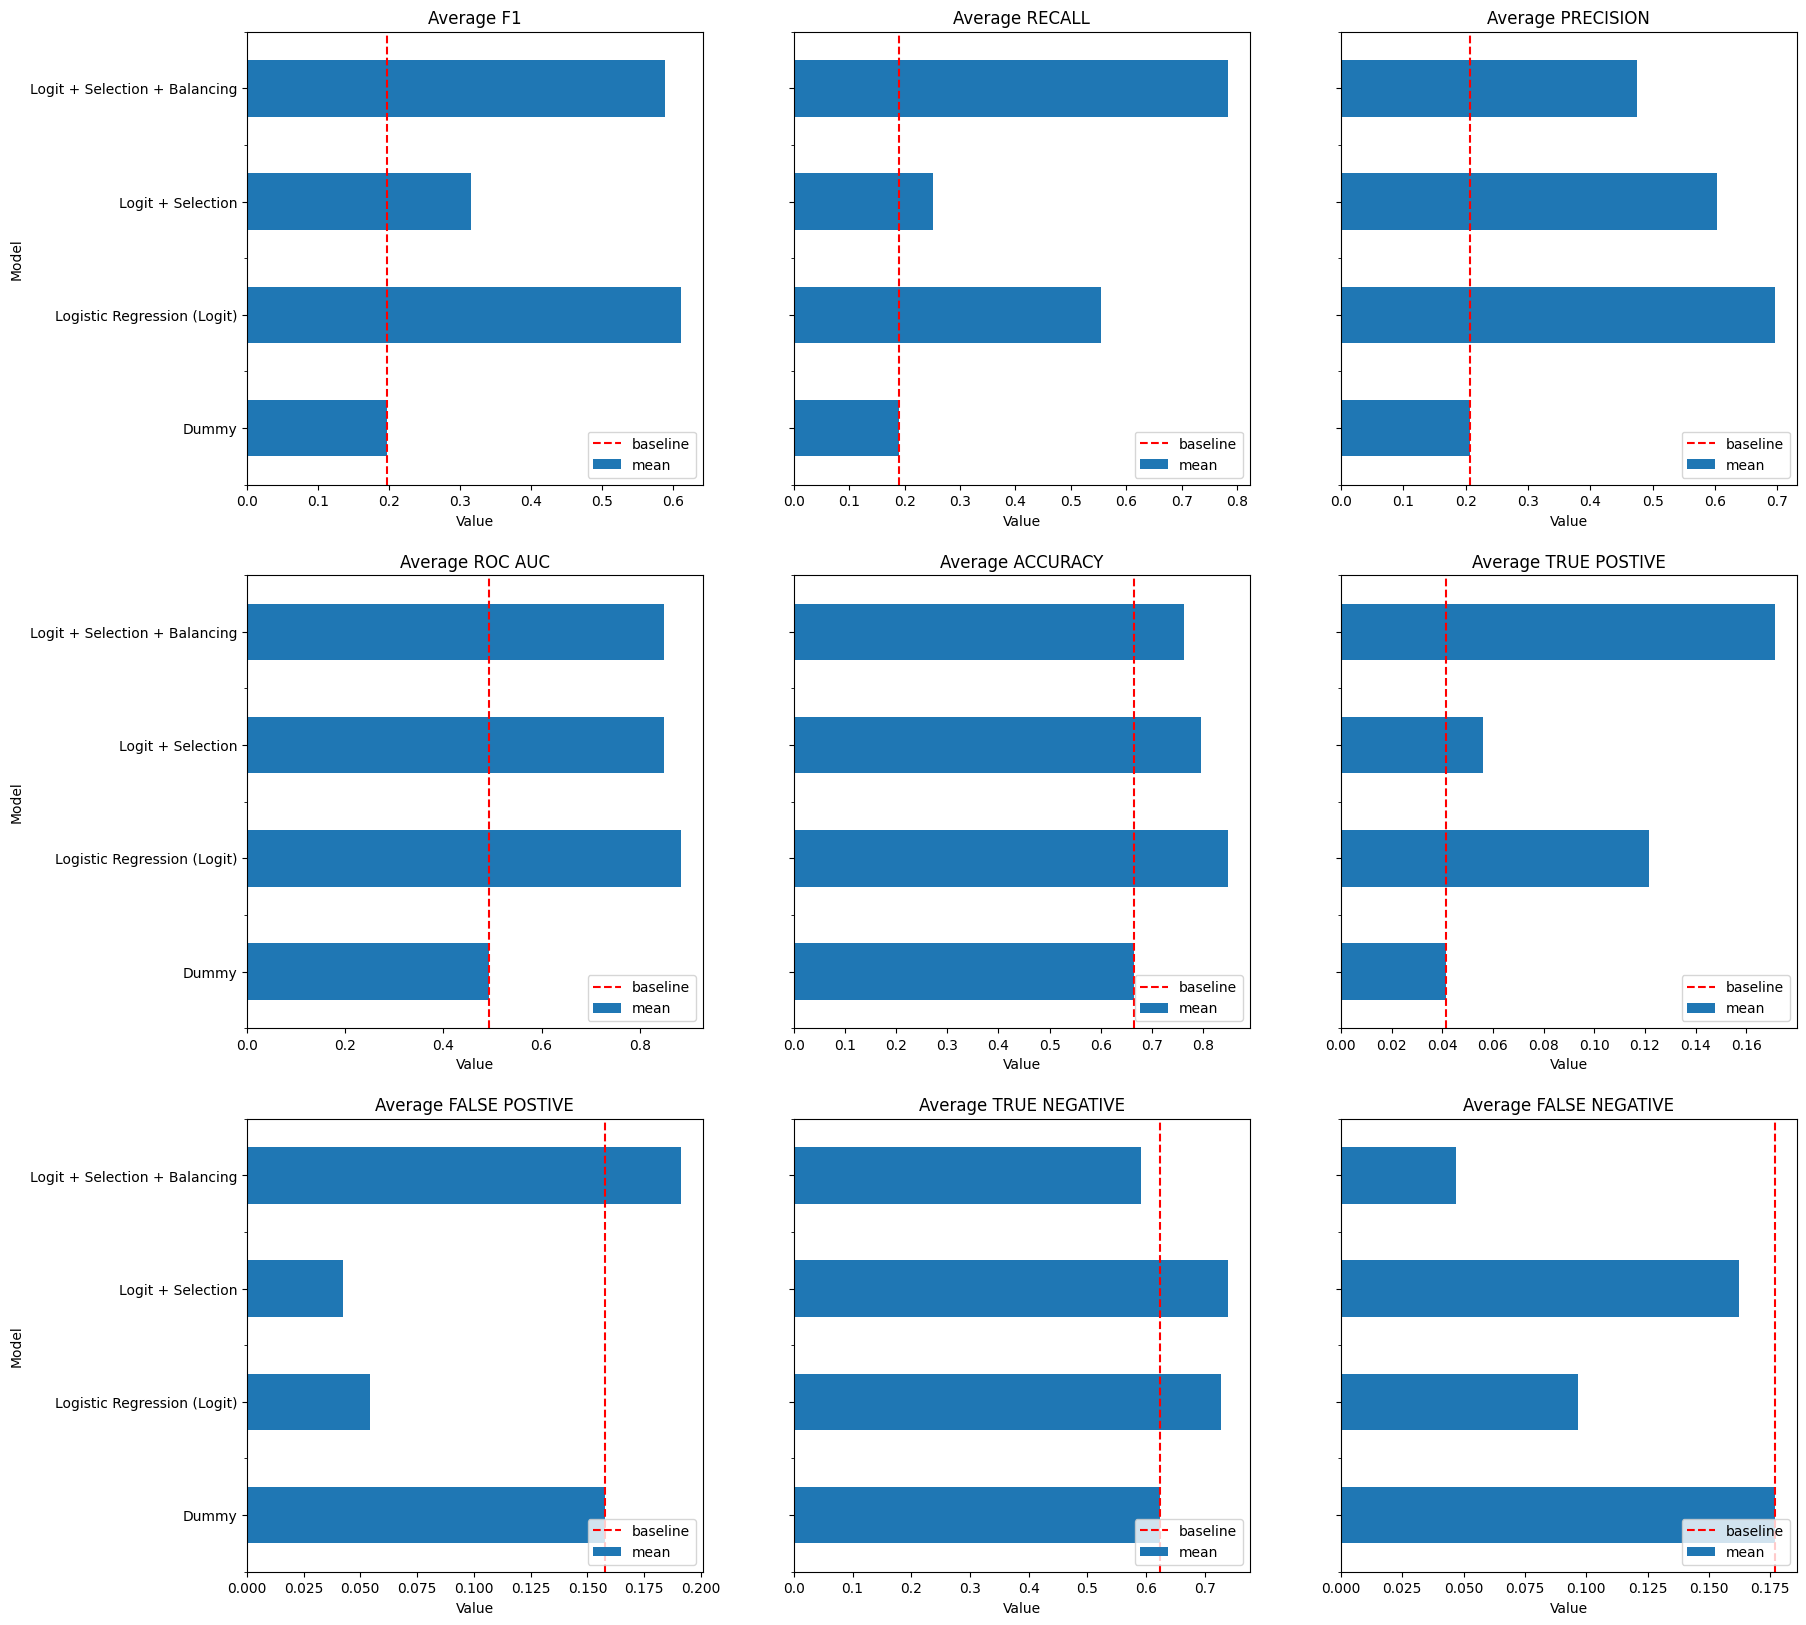

In [34]:
models = validation_results["model"].unique()
metrics = validation_results["metric"].unique()

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(20, 20), sharey=True)

for metric, ax in zip(metrics, axes.flatten()):
    baseline = validation_results.loc[
        (validation_results["metric"] == metric)
        & (validation_results["model"] == "Dummy"),
        "mean",
    ].values[0]
    ax.axvline(baseline, label="baseline", color="red", linestyle="dashed")
    validation_results[validation_results["metric"] == metric].plot.barh(
        y="mean",
        x="model",
        ax=ax,
        legend=False,
    )
    ax.set_title(
        "Average " + metric.removesuffix("_validation").replace("_", " ").upper()
    )
    ax.set_xlabel("Value")
    ax.set_ylabel("Model")
    ax.legend(loc="lower right")
    # ax.legend(loc="lower right")

As we can see above, most models way better metrics than the baseline for the most important metrics.

The best models are the Logistic Regression balanced and unblanced. But we can still get great results while using only a fraction of the features.

Balacing has a trade-off between precision and recall, because it shifts the resulting probability curve. Depending on how we want to present the model,
we need to delve a bit deeper on the probability curve and analyze the shape.


### Next steps

It might be worthwhile to invest time into better features and models such as adding Benchmark Rates or using Gradient Boosting Trees, but doing so will increase:

- Complexity of the model.
- Analysis time.
- Complexity of the engineering time to implement this.
